In [1]:
import os
import random
import shutil

Step 1. Create your custom dataset featuring 3 custom categories of at least 100 images each

## Downloading CIFAR10 data

In [2]:
import urllib.request

# Define the download URL and target path
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
target_path = "cifar10.tgz"

# Download the dataset
urllib.request.urlretrieve(dataset_url, target_path)

print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [3]:
import tarfile

# Extract the downloaded file
with tarfile.open(target_path) as tar:
    tar.extractall()

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [4]:
#Printing class names in cifar10
import os

train_path = 'cifar10/train'
class_names = sorted(os.listdir(train_path))

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


 Step 2. Split this data between 80% training and 20% test

## Extracting 3 classes from CIFAR10 data to make a subset and spliting data into train and test

In [5]:
# List of selected categories
selected_categories = ['airplane', 'cat', 'dog']

# Target folder to copy the images
target_path = 'subset_cifar10'

# Ensure the target folder exists
if not os.path.exists(target_path):
    os.makedirs(target_path)

#Creating a Target path to copy 3 classes of images
for category in selected_categories:
    category_path = os.path.join(target_path, category)
    if not os.path.exists(category_path):
        os.makedirs(category_path)


train_target_path = 'subset_cifar10/train'
test_target_path = 'subset_cifar10/test'

os.makedirs(train_target_path, exist_ok=True)
os.makedirs(test_target_path, exist_ok=True)


for category in selected_categories:
    category_folder = os.path.join(train_path, category)
    all_images = os.listdir(category_folder)
    random.shuffle(all_images)

    # Perform an 80/20 split
    split_idx = int(len(all_images) * 0.8)
    train_images = all_images[:split_idx]
    test_images = all_images[split_idx:]

    train_category_folder = os.path.join(train_target_path, category)
    test_category_folder = os.path.join(test_target_path, category)

    os.makedirs(train_category_folder, exist_ok=True)
    os.makedirs(test_category_folder, exist_ok=True)

    # Copy the training images
    for img in train_images:
        src = os.path.join(category_folder, img)
        dst = os.path.join(train_category_folder, img)
        shutil.copyfile(src, dst)

    # Copy the testing images
    for img in test_images:
        src = os.path.join(category_folder, img)
        dst = os.path.join(test_category_folder, img)
        shutil.copyfile(src, dst)

    print(f"Copied {len(train_images)} training images and {len(test_images)} testing images for {category}")

Copied 4000 training images and 1000 testing images for airplane
Copied 4000 training images and 1000 testing images for cat
Copied 4000 training images and 1000 testing images for dog


## Images from class 'cat', 'dog' and 'airplane' of have been exctarcted to different file path (target_path) and split into Train and test with 80:20 ratio.

##Displaying images from Train and Test set

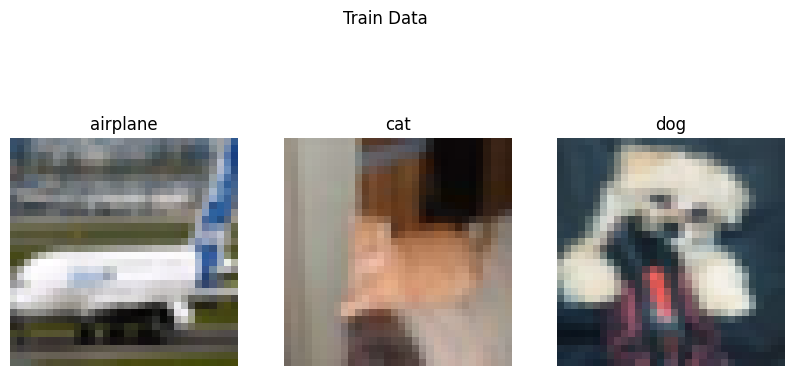

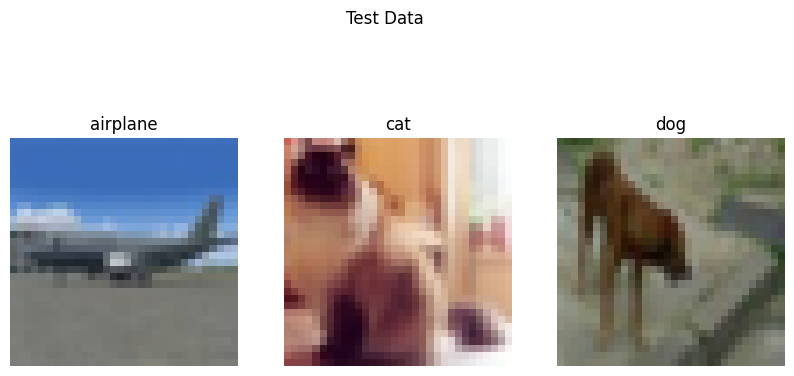

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

# function to display images from a given path
def display_images_from_path(data_path, title):
    fig, axes = plt.subplots(1, len(selected_categories), figsize=(10, 5))
    fig.suptitle(title)
    for i, category in enumerate(selected_categories):
        category_folder = os.path.join(data_path, category)
        all_images = os.listdir(category_folder)
        selected_image = random.choice(all_images)
        img_path = os.path.join(category_folder, selected_image)
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis('off')

    plt.show()

# Display images from the train dataset
display_images_from_path(train_target_path, "Train Data")

# Display images from the test dataset
display_images_from_path(test_target_path, "Test Data")

Step 3. Preprocess the data as you see fit

In [14]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define preprocessing transformations
preprocess_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training and test datasets with the preprocessing transformations applied
train_dataset = ImageFolder(root='subset_cifar10/train', transform=preprocess_transforms)
test_dataset = ImageFolder(root='subset_cifar10/test', transform=preprocess_transforms)

# Create DataLoaders for batching the data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the size of the training and test datasets
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")


Number of training images: 12000
Number of testing images: 3000


In [15]:
for image_batch, labels_batch in train_loader:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

torch.Size([64, 3, 32, 32])
torch.Size([64])


The image_batch is a torch tensor of the shape (64, 3, 32, 32). This is a batch of 64 images of shape 32x32x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (64,), these are corresponding labels to the 64 images.

In [16]:
print(len(train_loader.dataset))
print(train_loader.dataset[0][0].shape)
print(train_loader.dataset[1][0].shape)

12000
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


Step 4. Create a Convolutional Neural Network model to learn about your training set

## CNN model with input dimensions 32 * 32 * 3, with 3 convolution layers followed by Relu activation function and Maxplooing

In [17]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()

        # For CIFAR-10 (32x32 input size):

        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input dimensions for CIFAR-10
img_height, img_width = 32, 32

num_classes = 3

# Instantiate the model for CIFAR-10
model = CNNModel(num_classes, img_height, img_width)

# Print the model architecture
print(model)


CNNModel(
  (rescaling): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


## Training CCN Model

In [18]:
import torch.optim as optim
import torch.nn.functional as F

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Training loop
def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            # Track training loss
            train_loss += loss.item() * images.size(0)

        # Print training statistics
        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 0.7899, Accuracy: 0.5826
Epoch 2/10, Loss: 0.6622, Accuracy: 0.6762
Epoch 3/10, Loss: 0.6105, Accuracy: 0.7105
Epoch 4/10, Loss: 0.5504, Accuracy: 0.7492
Epoch 5/10, Loss: 0.5062, Accuracy: 0.7693
Epoch 6/10, Loss: 0.4744, Accuracy: 0.7902
Epoch 7/10, Loss: 0.4408, Accuracy: 0.8110
Epoch 8/10, Loss: 0.4066, Accuracy: 0.8254
Epoch 9/10, Loss: 0.3631, Accuracy: 0.8465
Epoch 10/10, Loss: 0.3357, Accuracy: 0.8618


CCN model has achieve 86% accuracy on Train set

Step 5. Make predictions on the test data and compare them to the expected categories

## Evaluating the performance of CCN Model

In [ ]:
model.eval()
classes = ['airplane', 'cat', 'dog']

correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        # Apply softmax to get the probabilities
        probabilities = torch.softmax(outputs, dim=1)

        # Convert predicted probabilities to predicted class names
        predicted_classes = [classes[torch.argmax(prob).item()] for prob in probabilities]

        # Calculate accuracy
        _, predicted_indices = torch.max(outputs, 1)
        correct += (predicted_indices == labels).sum().item()
        total += labels.size(0)

        # Print predictions for the first 5 samples in the batch
        for i in range(5):
            predicted_class = predicted_classes[i]
            confidence = torch.max(probabilities[i]).item()
            true_class = classes[labels[i].item()]

            print(f"Predicted: {predicted_class}, True: {true_class}, Confidence: {confidence * 100:.2f}%")

# Calculate and print the test accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Predicted: airplane, True: airplane, Confidence: 100.00%
Predicted: airplane, True: airplane, Confidence: 99.82%
Predicted: airplane, True: airplane, Confidence: 99.99%
Predicted: airplane, True: airplane, Confidence: 49.19%
Predicted: airplane, True: airplane, Confidence: 85.82%
Predicted: airplane, True: airplane, Confidence: 99.89%
Predicted: airplane, True: airplane, Confidence: 99.29%
Predicted: airplane, True: airplane, Confidence: 85.54%
Predicted: airplane, True: airplane, Confidence: 99.57%
Predicted: airplane, True: airplane, Confidence: 84.21%
Predicted: airplane, True: airplane, Confidence: 99.80%
Predicted: airplane, True: airplane, Confidence: 99.99%
Predicted: airplane, True: airplane, Confidence: 99.28%
Predicted: cat, True: airplane, Confidence: 53.47%
Predicted: cat, True: airplane, Confidence: 66.48%
Predicted: airplane, True: airplane, Confidence: 99.69%
Predicted: airplane, True: airplane, Confidence: 98.14%
Predicted: airplane, True: airplane, Confidence: 86.95%
P

Test accuracy of CNN model is 77%

Comparing Predictions on few Samples

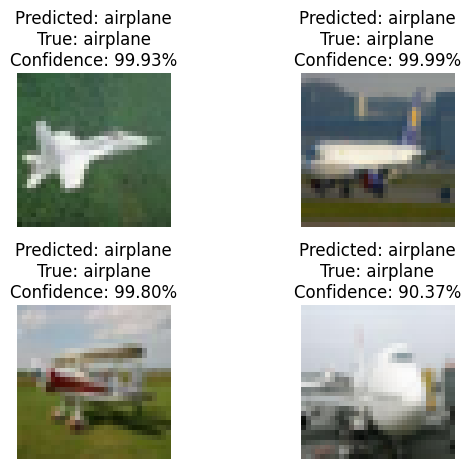

In [ ]:
# Disable gradient calculation for evaluation
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        # Forward pass: Get the outputs from the model
        outputs = model(images)

        # Apply softmax to get probabilities
        probabilities = torch.softmax(outputs, dim=1)

        # Get predicted classes
        predicted_classes = [classes[torch.argmax(prob).item()] for prob in probabilities]

        # Display the first 4 images from the batch with predictions and true labels
        for i in range(4):
            image = images[i].permute(1, 2, 0).numpy()
            image = (image * 0.5) + 0.5

            true_class = classes[labels[i].item()]
            predicted_class = predicted_classes[i]
            confidence = torch.max(probabilities[i]).item()

            # Plot the image and its prediction
            plt.subplot(2, 2, i + 1)
            plt.imshow(image)
            plt.title(f"Predicted: {predicted_class}\nTrue: {true_class}\nConfidence: {confidence * 100:.2f}%")
            plt.axis('off')

        # Show the images and predictions
        plt.tight_layout()
        plt.show()

        # Only visualize the first batch, so break after the first iteration
        if batch_idx == 0:
            break

Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

### Building GoogleNet Model
The code loads the GoogleNet model pre-trained on ImageNet



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

#Loading pre-trained GoogleNet model
googlenet = models.googlenet(pretrained=True)


All layers in the model are frozen except the final fully connected layer, so only the last layer's weights will be updated during training.

In [ ]:
#Freezing all layers except the last
for param in googlenet.parameters():
    param.requires_grad = False

The original output layer (for ImageNet with 1000 classes) is replaced with a new linear layer to match the number of classes in the dataset

In [ ]:
#Implementing with GoogleNet's default fc layer 1024
googlenet.fc = nn.Linear(1024, num_classes)
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Step 7: Train the GoogleNet model and compare the accuracy with the first model.

## Training GoogleNet

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(googlenet.fc.parameters(), lr=0.001)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    running_loss = 0.0
    train_acc = 0.0
    train_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # Forward pass
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item() * inputs.size(0)
        train_loss += loss.item() * inputs.size(0)

        # Compute training accuracy
        acc = accuracy(outputs, labels)
        train_acc += acc.item() * inputs.size(0)

    # Compute the average loss and accuracy for the epoch
    epoch_loss = train_loss / len(train_loader.dataset)
    epoch_acc = train_acc / len(train_loader.dataset)

    # Print training statistics for the current epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

print("Finished Training")


Epoch 1/10, Loss: 0.9272, Accuracy: 0.5443
Epoch 2/10, Loss: 0.8335, Accuracy: 0.5972
Epoch 3/10, Loss: 0.8199, Accuracy: 0.6138
Epoch 4/10, Loss: 0.8093, Accuracy: 0.6192
Epoch 5/10, Loss: 0.8146, Accuracy: 0.6137
Epoch 6/10, Loss: 0.8094, Accuracy: 0.6114
Epoch 7/10, Loss: 0.8089, Accuracy: 0.6210
Epoch 8/10, Loss: 0.7992, Accuracy: 0.6220
Epoch 9/10, Loss: 0.8010, Accuracy: 0.6228
Epoch 10/10, Loss: 0.8024, Accuracy: 0.6233
Finished Training


## Evaluating Performance of GoogleNet Model

In [ ]:
model.eval()

classes = ['airplane', 'cat', 'dog']

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)

        # Apply softmax to get the probabilities
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted_indices = torch.max(outputs, 1)

        # Update the correct predictions and total samples count
        correct += (predicted_indices == labels).sum().item()
        total += labels.size(0)

        # Print predictions for the first 10 samples in the batch
        for i in range(10):
            predicted_class = classes[predicted_indices[i].item()]
            confidence = torch.max(probabilities[i]).item()
            true_class = classes[labels[i].item()]

            print(f"Predicted: {predicted_class}, True: {true_class}, Confidence: {confidence * 100:.2f}%")

# Calculate and print the test accuracy over all the batches
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Predicted: airplane, True: airplane, Confidence: 100.00%
Predicted: airplane, True: airplane, Confidence: 99.82%
Predicted: airplane, True: airplane, Confidence: 99.99%
Predicted: airplane, True: airplane, Confidence: 49.19%
Predicted: airplane, True: airplane, Confidence: 85.82%
Predicted: dog, True: airplane, Confidence: 58.62%
Predicted: airplane, True: airplane, Confidence: 100.00%
Predicted: cat, True: airplane, Confidence: 70.71%
Predicted: airplane, True: airplane, Confidence: 99.99%
Predicted: airplane, True: airplane, Confidence: 99.92%
Predicted: airplane, True: airplane, Confidence: 99.89%
Predicted: airplane, True: airplane, Confidence: 99.29%
Predicted: airplane, True: airplane, Confidence: 85.54%
Predicted: airplane, True: airplane, Confidence: 99.57%
Predicted: airplane, True: airplane, Confidence: 84.21%
Predicted: airplane, True: airplane, Confidence: 99.99%
Predicted: airplane, True: airplane, Confidence: 99.96%
Predicted: airplane, True: airplane, Confidence: 69.48%


# **Performance Comparison on CNN and GoogleNet Models**

### CNN Model
The Training accuracy is 86% and Testing accuracy is 77%. Since the testing accuracy is lower than training accuracy there seems to be a overfitting. The model is not generalizing well on unseen data.

### GoogleNet Model
Training accuracy is 62% and test accracy is 77%. GoogleNet, despite a lower training accuracy, has excellent test accuracy. This suggests that GoogleNet, likely due to its complex architecture and regularization techniques (e.g., dropout, batch normalization), is able to generalize well and avoid overfitting, even though it has not yet fully optimized on the training data.

Hence, GoogleNet is a better model as it has complex architecture with multiple layers and inception module to extract more sophisticated features from the dataset like CIFAR10.